<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/07_Milestone_project_1_Food_vision_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project 1: Food Vision Big

## Check GPU

Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to Tesla T4 (from within Google Colab) or if we're using our own hardware , our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

**Resource:** You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision Documentation: https://www.tensorflow.org/guide/mixed_precision

In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 2.9 MB 51.1 MB/s 
     |████████████████████████████████| 3.8 MB 60.2 MB/s 
     |████████████████████████████████| 462 kB 77.4 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.

**Note:** Degrading tensorflow version to 2.4.1 for applying the mixed precison float16 to reduce time and improve computation speed as tensorflow 2.5.0 version doesn't support mixed precision using EfficientNetBX models.

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
# Check for GPU?
!nvidia-smi

Sun Aug 15 20:35:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get helper functions

In past modules, we have created a bunch of helper functions to do small tasks required for our notebooks.

Rather than wewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on Github: https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py

--2021-08-15 20:35:04--  https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-15 20:35:04 (79.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, walk_through_dir

## Use TensorFlow Datasets to download data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

Read more about the data here: https://www.tensorflow.org/datasets/catalog/food101

In [ ]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list  = tfds.list_builders() # get all available datasets in TFDS 
print('food101' in datasets_list) # is our taf=rget dataset in the list of TFDS datasets

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSGJ9X2/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteSGJ9X2/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow datasets

To become one with our data, we want to find:
* Class Names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 384, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 55,
  Class name (str form): hot_dog
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image[:2]

<tf.Tensor: shape=(2, 384, 3), dtype=uint8, numpy=
array([[[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [104, 115, 121],
        [129, 140, 144],
        [119, 130, 134]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [117, 128, 134],
        [139, 150, 154],
        [142, 153, 157]]], dtype=uint8)>

In [ ]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

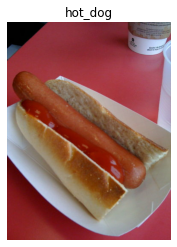

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

## Create preprocessing functions for our data

Neural Networks performs best when data is in a certain way (e.g. batched, normalized etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scales (values between 0 and 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions need to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

**Note:** Currently our data is in a (image, label) tuple format


In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` -> `float32` and reshapes
  image to [img_shape,img_shape,color_channels]
  """
  image = tf.image.resize(image, size=(img_shape,img_shape)) # reshape target images
  # image = image/255. # scale image values (not required with EfficientNetBX models)
  return tf.cast(image, dtype=tf.float32), label # return a tuple of (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [104 115 121]
  [129 140 144]
  [119 130 134]]

 [[  1   1   1]
  [  1   1   1]
  [  1   1   1]
  ...
  [117 128 134]
  [139 150 154]
  [142 153 157]]]...., 
Shape: (512, 384, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[  1.         1.         1.      ]
  [  1.         1.         1.      ]
  [  1.         1.         1.      ]
  ...
  [107.79069  120.3621   127.93351 ]
  [111.209465 122.209465 128.20946 ]
  [134.37245  145.37245  149.37245 ]]

 [[  1.         1.         1.      ]
  [  1.         1.         1.      ]
  [  1.         1.         1.      ]
  ...
  [126.44904  139.02045  146.59186 ]
  [131.88774  142.88774  148.88774 ]
  [115.81641  126.81641  130.8164  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



## Batch and prepare datasets

We're now going to make our data input pipelines run really fast.

For more resources on this, check here: https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training (and parellelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow , map this preprocessing function (`preprocess_img`) accross our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch".

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if needed).
* ModelCheckpoint callback to save our model's progress after feature extraction


In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training 

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https//www.tensorflow.org/guide/mixed_precision 

Mixed precision utilizes a combination of float16 and float32 data types to speed up model performance.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

**Exercise:** 

* Read about single precision floating point format: https://en.wikipedia.org/wiki/Single-precision_floating-point_format

* Read about half precision floating point format: https://en.wikipedia.org/wiki/Half-precision_floating-point_format

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1/255.) (inputs)

# Passing input through base model
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only or stays like that

# Passing through pooling layer
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)

# Passing through Dense layer
x = layers.Dense(len(class_names)) (x)

# Creating output layer
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)

# Combining the model
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=55>

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of the particular layer
* `layer.trainable`: is the layer trainable or not? (if `False` the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_ploicy`: the data type policy a layer computes on its variables with 

In [ ]:
# Check for the base model
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_1 False float32 <Policy "float32">
1 rescaling False float32 <Policy "mixed_float16">
2 normalization False float32 <Policy "float32">
3 stem_conv_pad False float32 <Policy "mixed_float16">
4 stem_conv False float32 <Policy "mixed_float16">
5 stem_bn False float32 <Policy "mixed_float16">
6 stem_activation False float32 <Policy "mixed_float16">
7 block1a_dwconv False float32 <Policy "mixed_float16">
8 block1a_bn False float32 <Policy "mixed_float16">
9 block1a_activation False float32 <Policy "mixed_float16">
10 block1a_se_squeeze False float32 <Policy "mixed_float16">
11 block1a_se_reshape False float32 <Policy "mixed_float16">
12 block1a_se_reduce False float32 <Policy "mixed_float16">
13 block1a_se_expand False float32 <Policy "mixed_float16">
14 block1a_se_excite False float32 <Policy "mixed_float16">
15 block1a_project_conv False float32 <Policy "mixed_float16">
16 block1a_project_bn False float32 <Policy "mixed_float16">
17 block2a_expand_conv False float32 <Policy "mixed

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the model
feature_extraction_history = model.fit(train_data,
                                       epochs=3,
                                       validation_data = test_data,
                                       validation_steps = int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                                              experiment_name="feature_extraction"),
                                                  model_checkpoint])

Saving TensorBoard log files to: TensorBoard/feature_extraction/20210815-205321
Epoch 1/3
2368/2368 [==============================] - 224s 79ms/step - loss: 2.3265 - accuracy: 0.4655 - val_loss: 1.2145 - val_accuracy: 0.6806
Epoch 2/3
2368/2368 [==============================] - 163s 68ms/step - loss: 1.3186 - accuracy: 0.6592 - val_loss: 1.1318 - val_accuracy: 0.7002
Epoch 3/3
2368/2368 [==============================] - 169s 70ms/step - loss: 1.1476 - accuracy: 0.6995 - val_loss: 1.0897 - val_accuracy: 0.7097


In [ ]:
# Evaluate model on the whole test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 54s 68ms/step - loss: 1.0902 - accuracy: 0.7048


[1.0901707410812378, 0.7047920823097229]

In [ ]:
# Save the feature_extraction model
model.save("feature_extraction_model")

INFO:tensorflow:Assets written to: feature_extraction_model/assets


INFO:tensorflow:Assets written to: feature_extraction_model/assets


In [ ]:
# Loading the model
loaded_model = tf.keras.models.load_model("feature_extraction_model")

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 48s 58ms/step - loss: 1.0902 - accuracy: 0.7048


[1.0901707410812378, 0.7047920823097229]

In [ ]:
import numpy as np
print(np.isclose(loaded_model_results, feature_extraction_results))

[ True  True]


## Steps to cover:
* Fine-tuning feature extraction model to beat the DeepFood Paper
* Evaluating model results on TensorBoard
* Evaluating model results by making and plotting predictions


In [ ]:
# Making the top 5 layers trainable
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Check for trainable layers 
for layer in base_model.layers[-20:]:
  print(layer.name, layer.trainable)

block6d_project_conv False
block6d_project_bn False
block6d_drop False
block6d_add False
block7a_expand_conv False
block7a_expand_bn False
block7a_expand_activation False
block7a_dwconv False
block7a_bn False
block7a_activation False
block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [ ]:
# Recompile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [ ]:
# Fine tune for 5 more epochs
fine_tune_epochs = 6
fine_tune_history = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch = feature_extraction_history.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                                     experiment_name="Fine_tune_model")])

Saving TensorBoard log files to: TensorBoard/Fine_tune_model/20210815-211530
Epoch 3/6
2368/2368 [==============================] - 170s 71ms/step - loss: 1.1764 - accuracy: 0.6909 - val_loss: 1.1125 - val_accuracy: 0.6992
Epoch 4/6
2368/2368 [==============================] - 164s 69ms/step - loss: 0.8914 - accuracy: 0.7548 - val_loss: 1.0497 - val_accuracy: 0.7193
Epoch 5/6
2368/2368 [==============================] - 163s 68ms/step - loss: 0.6841 - accuracy: 0.8050 - val_loss: 1.0959 - val_accuracy: 0.7121
Epoch 6/6
2368/2368 [==============================] - 164s 69ms/step - loss: 0.5324 - accuracy: 0.8415 - val_loss: 1.1526 - val_accuracy: 0.7137


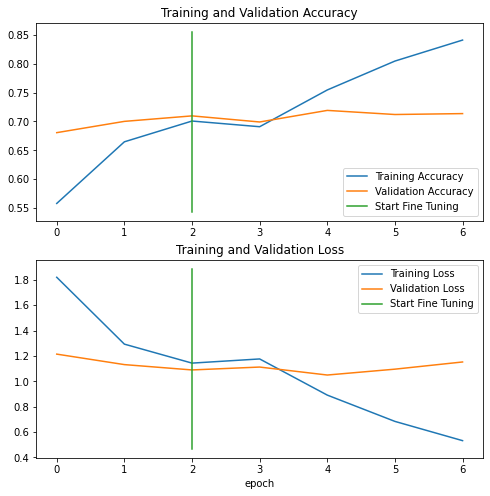

In [ ]:
compare_historys(feature_extraction_history,fine_tune_history,initial_epochs=3)